# Score Comparison
This notebook compares scaffold promiscuity scores (pscores) between badapple (original) and badapple_classic DB.

Note that scaffolds which have a score of 'None' are marked with a score of -1.0. If a given scaffold has a score of 'None' in **both** DBs then it is dropped before calculating metrics, otherwise it is kept.

## Setup

In [179]:
# define DB variables
ORIGINAL_DB_NAME = "badapple"
ORIGINAL_DB_HOST = "localhost"
ORIGINAL_DB_USER = "<your_usr>"
ORIGINAL_DB_PASSWORD = "<your_pw>"

COMPARISON_DB_NAME = "badapple_classic"
COMPARISON_DB_HOST = ORIGINAL_DB_HOST
COMPARISON_DB_USER = ORIGINAL_DB_USER
COMPARISON_DB_PASSWORD = ORIGINAL_DB_PASSWORD

In [144]:
# imports
import psycopg2
import psycopg2.extras
from psycopg2 import sql
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from rdkit import Chem
import numpy as np

## Connect to DBs

In [145]:
def db_connect(db_name: str, host: str, user: str, password: str):
    try:
        db_connection = psycopg2.connect(
            dbname=db_name,
            host=host,
            user=user,
            password=password,
            cursor_factory=psycopg2.extras.DictCursor,
        )
        db_connection.set_session(readonly=True)
        return db_connection
    except Exception as e:
        print(e)
        print(f"Error connecting to DB: {db_name}")
        return None

In [146]:
original_db_connection = db_connect(ORIGINAL_DB_NAME, ORIGINAL_DB_HOST, ORIGINAL_DB_USER, ORIGINAL_DB_PASSWORD)
comparison_db_connection = db_connect(COMPARISON_DB_NAME, COMPARISON_DB_HOST, COMPARISON_DB_USER, COMPARISON_DB_PASSWORD)

In [147]:
original_db_cur = original_db_connection.cursor()
comparison_db_cur = comparison_db_connection.cursor()

## Get pscores of shared scaffolds

In [148]:
def get_pscores(db_cursor, db_conn):
    query = sql.SQL("SELECT scafsmi, pscore FROM scaffold order by scafsmi")
    result = []
    try:
        db_cursor.execute(query)
        result = db_cursor.fetchall()
        return result
    except Exception:
        db_conn.rollback()
    return result

In [149]:
original_pscores = get_pscores(original_db_cur, original_db_connection)
comparison_pscores = get_pscores(comparison_db_cur, comparison_db_connection)

In [150]:
def get_pscore_df(pscore_list: list[list[str, int]]):
    df = pd.DataFrame(pscore_list, columns=['scafsmi', 'pscore'])
    # some compounds have 'None' as pscore (no evidence)
    # don't drop here in case this scaffold has a different score in other DB
    df['pscore'] = df['pscore'].fillna(-1.0) 
    return df

In [151]:
original_df = get_pscore_df(original_pscores)
comparison_df = get_pscore_df(comparison_pscores)

In [152]:
# get df containing shared scaffolds
shared_df = pd.merge(original_df, comparison_df, on='scafsmi')
shared_df.rename(columns={"pscore_x": "pscore_badapple", "pscore_y": "pscore_comparison"}, inplace=True)

# drop entries where both pscores were None
shared_df = shared_df[~((shared_df['pscore_badapple'] < 0) & (shared_df['pscore_comparison'] < 0))]

In [153]:
shared_df

,scafsmi,pscore_badapple,pscore_comparison
1,[BH2-](c1ccccc1)c1ccccc1,48.0,9.65
2,C1C2C1C1C3CC4C(C23)C41,0.0,0.02
3,C1C2C3C4OC5C3C1C1C2C4C51,0.0,0.06
4,C1C2C3CC4C5CC(C1C35)C24,3.0,3.69
5,C1=C2C3CCC4CC3C(CC2C2CCC3CCCCC3C2C1)O4,0.0,0.11
...,...,...,...
151469,S=P(NCCNP(=S)(N1CC1)N1CC1)(N1CC1)N1CC1,0.0,0.14
151470,S=P(NCCSCc1ccccc1)(N1CC1)N1CC1,0.0,0.88
151471,S=P(N=CN1CCOCC1)(N1CCOCC1)N1CCOCC1,0.0,0.01
151472,S=P(Nn1cnnc1)(c1ccccc1)c1ccccc1,0.0,0.39


## Calculate correlation, visualize with parity plot

In [154]:
def create_parity_plot(df: pd.DataFrame, x_col: str, y_col: str, title: str=None):
    plt.style.use('ggplot')
    plt.scatter(df[x_col], df[y_col], alpha=0.5)
    # Create parity line
    plt.plot(df[x_col], df[x_col], color='black')
    ax = plt.gca()
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    if title is not None:
        ax.set_title(title)
    plt.tight_layout()

In [155]:
# use scipy to calculate correlation + pval
correlation, p_value = pearsonr(shared_df["pscore_badapple"], shared_df["pscore_comparison"])

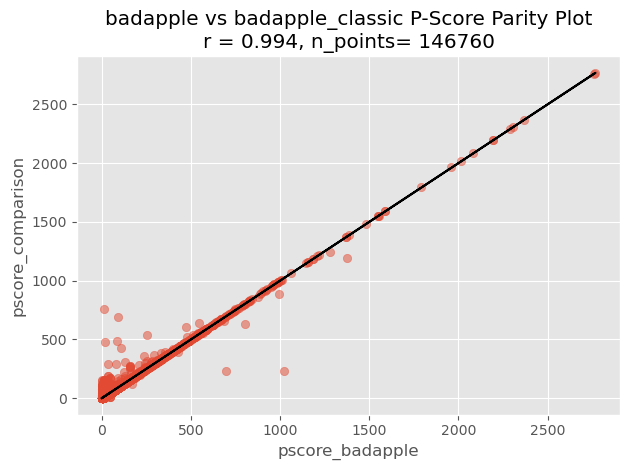

In [156]:
# visualize parity plot
plot_title = "badapple vs badapple_classic P-Score Parity Plot\nr = %.3f, n_points= %d" % (correlation, len(shared_df))
create_parity_plot(shared_df, "pscore_badapple", "pscore_comparison", plot_title)
plt.show()

## Get and view outliers

In [157]:
def get_outliers_df(df: pd.DataFrame, col1: str, col2: str, percent_threshold: float, min_abs_diff: float):
    df['abs_diff'] = (df[col1] - df[col2]).abs()
    df['threshold'] = df[col1] * percent_threshold
    outliers_df = shared_df[(df['abs_diff'] > df['threshold']) & (df['abs_diff'] > min_abs_diff)]
    # drop temp columns
    df.drop(columns=["abs_diff", "threshold"], inplace=True)
    return outliers_df

In [158]:
threshold = 0.20 # 0.20 means 20% difference
min_abs_diff = 5 # pscores must differ by at least 5 to be "outliers"
pscore_outliers_df = get_outliers_df(shared_df, "pscore_badapple", "pscore_comparison", threshold, min_abs_diff)

In [159]:
pscore_outliers_df

,scafsmi,pscore_badapple,pscore_comparison,abs_diff,threshold
1,[BH2-](c1ccccc1)c1ccccc1,48.0,9.65,38.35,9.6
9,C1=C2C3CCCCC3CCC2C2CCC3CCCCC3C2C1,88.0,115.19,27.19,17.6
11,C1=C2C3CCCCC3CCC2C2CCC3CC(OC4CCCCO4)CCC3C2C1,110.0,161.92,51.92,22.0
14,C1=C2C3CCCCC3CCC2C2CCC3CC(OC4CC(OC5CCCCO5)CCO4...,23.0,83.73,60.73,4.6
15,C1=C2C3CCCCC3CCC2C2CCC3CC(OC4OCCCC4OC4CCCCO4)C...,91.0,146.93,55.93,18.2
...,...,...,...,...,...
149263,S=C1N(CCN2CCCC2)CC(Cc2ccccc2)N1CCc1ccccc1,17.0,97.30,80.30,3.4
149264,S=C1N(CCN2CCCC2)CCN1CC1CCCCC1,18.0,118.89,100.89,3.6
149265,S=C1N(CCN2CCCC2)CCN1CC1CCCCCC1,14.0,111.49,97.49,2.8
149266,S=C1N(CCN2CCCC2CN2C(=S)NCC2Cc2ccccc2)CCN1CC1CC...,5.0,100.13,95.13,1.0


In [160]:
pscore_outliers_df.to_csv(f"pscore_outliers_thresh={threshold}-min_abs_diff={min_abs_diff}.tsv", index=False, sep="\t")

In [161]:
def get_outliers_img(df: pd.DataFrame, mols_per_row: int):
    mols = [Chem.MolFromSmiles(smi) for smi in df["scafsmi"]]
    legends = [
        f"{row.scafsmi}\npscore_badapple={row.pscore_badapple}\npscore_comparison={row.pscore_comparison}"
        for row in df.itertuples(index=False)
    ]
    img = Chem.Draw.MolsToGridImage(mols=mols, legends=legends, molsPerRow=mols_per_row, useSVG=True, subImgSize=(300, 300), maxMols=len(df))
    return img

In [162]:
# visualize 9 outliers w/ largest absolute difference in pscore
top_9_outliers = pscore_outliers_df.nlargest(9, 'abs_diff')
top_9_outliers

,scafsmi,pscore_badapple,pscore_comparison,abs_diff,threshold
30392,[NH2+]=c1ccc2cc3ccccc3oc-2c1,1020.0,232.05,787.95,204.0
85787,O=C(Cn1ccnn1)NCCCCCCCCCCC(=O)N1CCN(c2ncncn2)CC1,12.0,755.75,743.75,2.4
85789,O=C(Cn1ccnn1)NCCCCCCCCCCC(=O)N1CCNCC1,92.0,688.50,596.50,18.4
30391,[NH2+]=c1ccc2c(-c3ccccc3)c3ccccc3oc-2c1,697.0,232.05,464.95,139.4
24856,C=C1C=CNN1,16.0,474.06,458.06,3.2
24358,C=c1cc2c(oc1=O)=CC(=O)C=C2,85.0,488.92,403.92,17.0
26345,C=C(c1ccccc1)c1ccccc1,107.0,428.38,321.38,21.4
24795,C=C1C=CNC=C1,256.0,534.93,278.93,51.2
22901,c1nc(N2CCNCC2)nc(N2CCNCC2)n1,33.0,291.13,258.13,6.6


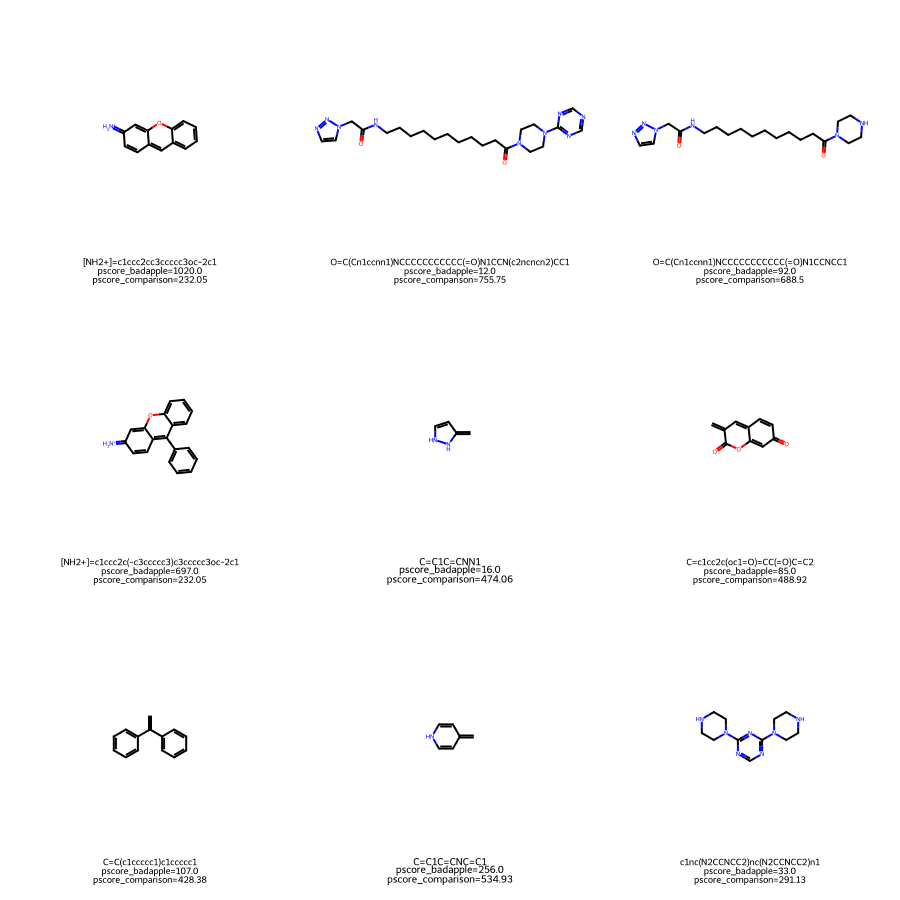

In [163]:
get_outliers_img(top_9_outliers, 3)

In [164]:
# create image visualizing all outliers, save
mols_per_row = int(len(pscore_outliers_df) ** 0.5)
full_image = get_outliers_img(pscore_outliers_df, mols_per_row)


In [165]:
save_path = f"outliers_image_thresh={threshold}-min_abs_diff={min_abs_diff}.svg"
with open(save_path, "w") as f:
    f.write(full_image.data)

## Score histograms

In [166]:
def show_score_histogram(pscore_values: pd.Series):
    # Define the ranges and corresponding colors
    ranges = [(-float('inf'), 0), (0, 100), (100, 300), (300, float('inf'))]
    colors = ['grey', 'green', 'yellow', 'red']
    labels = ['pscore = ~', '0 <= pscore < 100', '100 <= pscore < 300', 'pscore >= 300']

    # Create lists to hold the pscore values for each range
    pscore_lists = [[] for _ in ranges]
    counts = [0] * len(ranges)

    # Distribute the pscore values into the corresponding lists
    for pscore in pscore_values:
        for i, (low, high) in enumerate(ranges):
            if low <= pscore < high:
                pscore_lists[i].append(pscore)
                counts[i] += 1
                break
    
    # Define the bin edges in increments of 25
    bin_size = 25
    # min score is 0
    bin_edges = np.arange(-bin_size, max(pscore_values) + bin_size, bin_size)

    # Plot the histogram
    plt.figure(figsize=(10, 6))
    for pscore_list, color in zip(pscore_lists, colors):
        plt.hist(pscore_list, bins=bin_edges, color=color, edgecolor='black', alpha=0.7)

    plt.xlabel('pscore')
    plt.ylabel('Frequency')
    plt.yscale("log")
    plt.title(f'Histogram of pscore values\nBin Size={bin_size}')

    total_count = len(pscore_values)
    legend_labels = [f'{label} : {count}' for label, count in zip(labels, counts)]
    legend_labels.append(f'Total: {total_count}')
    plt.legend(legend_labels, title="Count totals", loc='upper right')

    plt.show()

### Original DB (badapple)

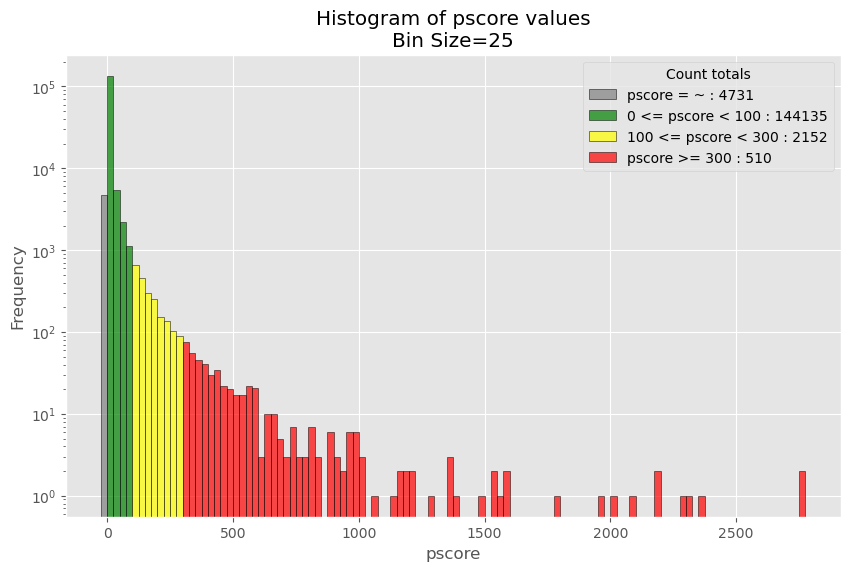

In [167]:
show_score_histogram(original_df["pscore"])

### New DB (badapple_classic)

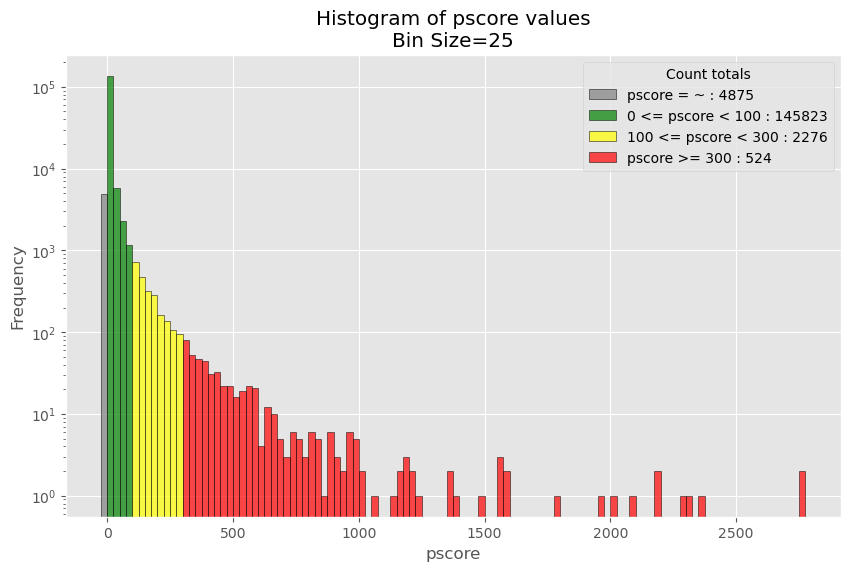

In [168]:
show_score_histogram(comparison_df["pscore"])

## Compare "InDrug" Scores
This section compares the scores for scaffolds which were found to be present in approved drugs from [DrugCentral](https://drugcentral.org/).

### Get pscores of indrug scaffolds

In [169]:
def get_pscores_ind(db_cursor, db_conn):
    query = sql.SQL("SELECT scafsmi, pscore FROM scaffold WHERE in_drug ORDER BY scafsmi")
    result = []
    try:
        db_cursor.execute(query)
        result = db_cursor.fetchall()
        return result
    except Exception:
        db_conn.rollback()
    return result

In [170]:
original_pscores_ind = get_pscores_ind(original_db_cur, original_db_connection)
comparison_pscores_ind = get_pscores_ind(comparison_db_cur, comparison_db_connection)

In [171]:
original_df_ind = get_pscore_df(original_pscores_ind)
comparison_df_ind = get_pscore_df(comparison_pscores_ind)

In [172]:
# get df containing shared scaffolds
shared_df_ind = pd.merge(original_df_ind, comparison_df_ind, on='scafsmi')
shared_df_ind.rename(columns={"pscore_x": "pscore_badapple", "pscore_y": "pscore_comparison"}, inplace=True)

# drop entries where both pscores were None
shared_df_ind = shared_df_ind[~((shared_df_ind['pscore_badapple'] < 0) & (shared_df['pscore_comparison'] < 0))]

/tmp/ipykernel_50238/1199856565.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  shared_df_ind = shared_df_ind[~((shared_df_ind['pscore_badapple'] < 0) & (shared_df['pscore_comparison'] < 0))]


In [173]:
shared_df_ind

,scafsmi,pscore_badapple,pscore_comparison
0,C1=C2c3cccc4[nH]cc(c34)CC2NCC1,280.0,280.64
1,C1C2CC3CC1CC(C2)C3,228.0,229.18
2,c1c2c(cc3c1OCO3)CCCC2,0.0,0.57
3,c1c2c(cc3c1OCO3)CNCC2,2.0,2.23
4,C1=C2CCC3C4CCCC4CCC3C2Cc2cnoc21,3.0,3.14
...,...,...,...
2075,S=C(Nc1ccccc1)Nc1ccccc1,161.0,161.36
2076,S=C(Nc1ccccc1)Oc1ccc2ccccc2c1,0.0,0.87
2077,S=C(Nc1ccccn1)Oc1ccc2c(c1)CCCC2,-1.0,-1.00
2078,S=C(Nc1ccc(Nc2ccccc2)cc1)N1CCNCC1,0.0,0.31


### Parity Plot for shared indrug scafs

In [174]:
# use scipy to calculate correlation + pval
correlation_ind, p_value_ind = pearsonr(shared_df_ind["pscore_badapple"], shared_df_ind["pscore_comparison"])

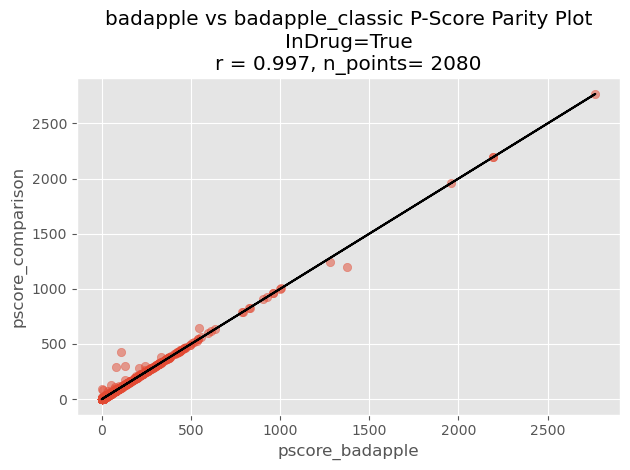

In [175]:
# visualize parity plot
plot_title = "badapple vs badapple_classic P-Score Parity Plot\nInDrug=True\nr = %.3f, n_points= %d" % (correlation_ind, len(shared_df_ind))
create_parity_plot(shared_df_ind, "pscore_badapple", "pscore_comparison", plot_title)
plt.show()

### Histogram of scores

#### Original DB (badapple)

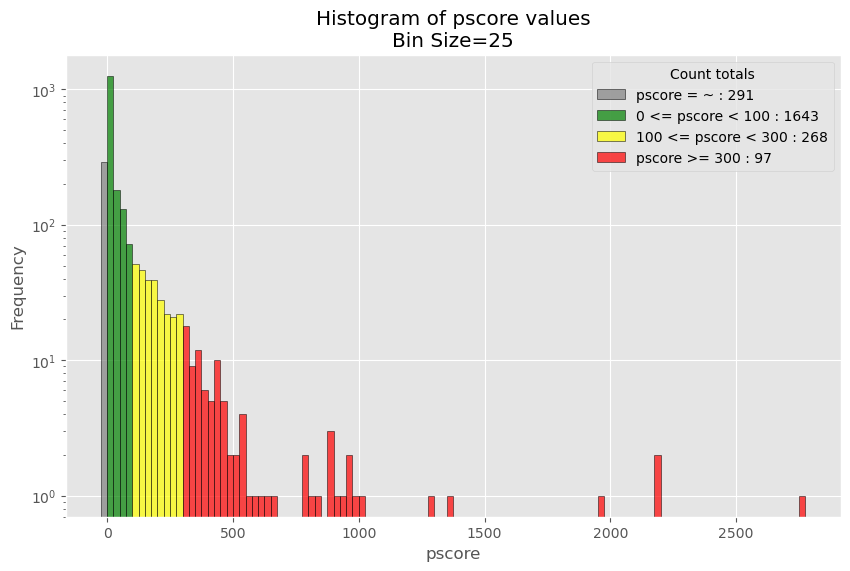

In [176]:
show_score_histogram(original_df_ind["pscore"])

#### New DB (badapple_classic)

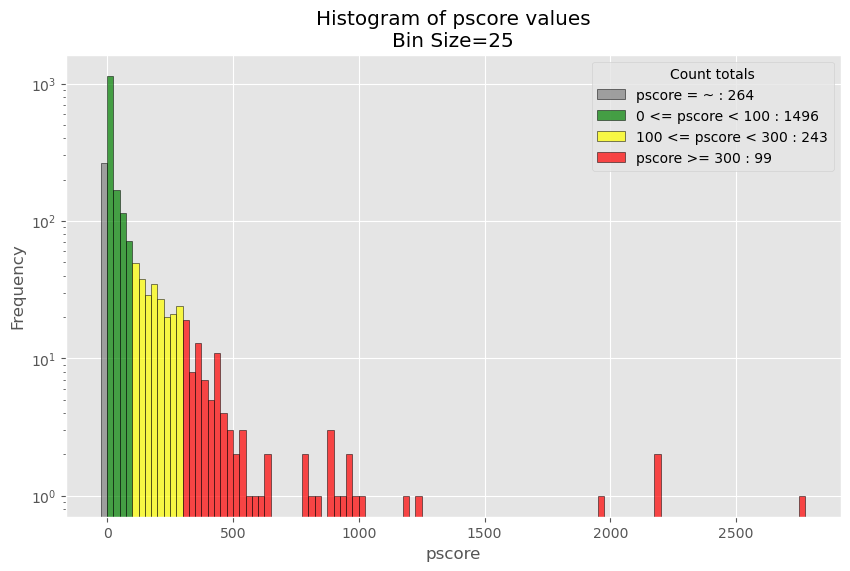

In [177]:
show_score_histogram(comparison_df_ind["pscore"])

## Close DB connections

In [178]:
# Close the cursors
original_db_cur.close()
comparison_db_cur.close()

# Close the connections
original_db_connection.close()
comparison_db_connection.close()